# part0: imports

In [2]:
import os, sys, pathlib
from pprint import pprint 
from importlib import reload
import logging
from typing import Callable
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.simplefilter("ignore")



import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator


import pyaldata as pyal


try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    from params import monkey_defs
    from params import mouse_defs
    set_rc =  params.set_rc_params
    root = params.root

finally:
    os.chdir(nbPath)


# test the depth of the neurons

In [5]:
from scipy.io import loadmat


path = root / 'mouse-data-raw' / 'js2p0_tbytSpkHandJsTrj10msBin_WR38_052219.mat'

a = loadmat(path)

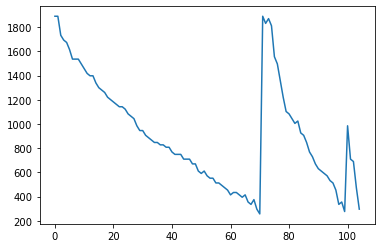

In [13]:
plt.plot(a['depthCtx'])

# check the multi-D array

In [7]:
animalList = ['Chewie', 'Mihili']

animalFiles={}
for animal in animalList:
    animalFiles[animal] = utility.find_file(root / animal,'mat')

# keeping 1 session per animal
fileList = ['/data/Chewie/Chewie_CO_CS_2016-10-14.mat', '/data/Mihili/Mihili_CO_VR_2014-03-03.mat']
fileList = ['/data/Chewie/Chewie_CO_CS_2016-10-14.mat']


df_data=[]
for fname in fileList:
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)
    df_data.append(df)
#     dt.summary(df)

In [8]:
pairFileList_ready = [prep_general(df) for  df in df_data]
df = pairFileList_ready[0]

/home/mostafa/Repositories/MyPyalData/pyaldata/tools.py:939: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [27]:
AllData1 = dt.get_data_array(pairFileList_ready, prep_epoch, area='M1', n_components=n_components)

4


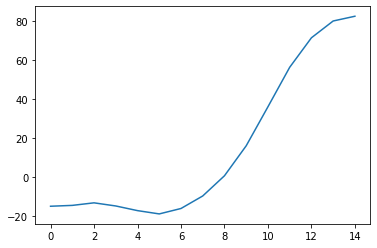

In [28]:
print(df.target_id[0])

plt.plot(AllData1[0,4,0,:,0])

In [30]:
df_ = pyal.restrict_to_interval(df, epoch_fun=prep_epoch)
rates = np.concatenate(df_['M1_rates'].values, axis=0)
rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates)
df = pyal.apply_dim_reduce_model(df_, rates_model, 'M1_rates', 'M1_pca');

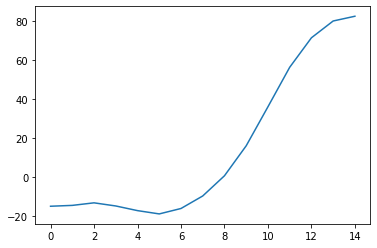

In [32]:
plt.plot(df.M1_pca[0][:,0])

In [37]:
n_t = AllData1.shape[-2]

n_t

15

In [50]:
for sessionData1 in AllData1:
    data1 = np.reshape(sessionData1[4:,:5,:,:], (-1,n_components))
data1 = np.array(data1)

data1.shape

(300, 10)

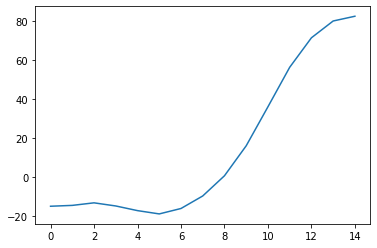

In [53]:
plt.plot(data1[:n_t,0])

# check the mouse data

In [3]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root / animal,'mat'))


df_data=[]
for fname in animalFiles[:]:
    print(fname)
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)
    df_data.append(df)
#     dt.summary(df)

/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR40_081919_ss.mat
field unitTimeBCtx could not be converted to int.
field unitTimeBStr could not be converted to int.
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR39_100219_ss.mat
field unitTimeBCtx could not be converted to int.
field unitTimeBStr could not be converted to int.
array field maxRchSpeed could not be converted to int.
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR38_052219_ss.mat
field unitTimeBCtx could not be converted to int.
field unitTimeBStr could not be converted to int.
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR40_082019_ss.mat
field unitTimeBCtx could not be converted to int.
field unitTimeBStr could not be converted to int.
array field maxRchSpeed could not be converted to int.
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR44_031020_ss.mat
field unitTimeBCtx could not be converted to int.
field unitTimeBStr could not be converted to int.
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR39_100819_n

In [4]:
df = df_data[0]

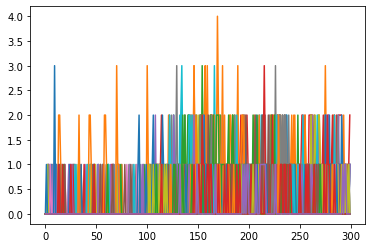

In [26]:
plt.plot(df.unitTimeBCtx[50].toarray().T[:,:]);

# Improving `get_data_array`

In [15]:
def get_data_array(data_list: list[pd.DataFrame], epoch: Callable =None , area: str ='M1', model: Callable =None) -> np.ndarray:
    """
    Applies the `model` to the data and return a data matrix of the shape: sessions x targets x trials x time x modes
    with the minimum number of trials and timepoints shared across all the datasets/targets.
    
    Parameters
    ----------
    `data_list`: list of pd.dataFrame datasets from pyalData (could also be a single dataset)
    `epoch`: an epoch function of the type `pyal.generate_epoch_fun`
    `area`: area, either: 'M1', or 'S1', or 'PMd', ...
    `model`: a model that implements `.fit()`, `.transform()` and `n_components`. By default: `PCA(10)`. If it's an integer: `PCA(integer)`.
    
    Returns
    -------
    `AllData`: np.ndarray

    Signature
    -------
    AllData = get_data_array(data_list, execution_epoch, area='M1', model=10)
    all_data = np.reshape(AllData, (-1,10))
    """
    if isinstance(data_list, pd.DataFrame):
        data_list = [data_list]
    if model is None:
        model = PCA(n_components=10, svd_solver='full')
    elif isinstance(model, int):
        model = PCA(n_components=model, svd_solver='full')
    
    field = f'{area}_rates'
    n_shared_trial = np.inf
    target_ids = np.unique(data_list[0].target_id)
    for df in data_list:
        for target in target_ids:
            df_ = pyal.select_trials(df, df.target_id== target)
            n_shared_trial = np.min((df_.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)

    # finding the number of timepoints
    if epoch is not None:
        df_ = pyal.restrict_to_interval(data_list[0],epoch_fun=epoch)
    n_timepoints = int(df_[field][0].shape[0])

    # pre-allocating the data matrix
    AllData = np.empty((len(data_list), len(target_ids), n_shared_trial, n_timepoints, model.n_components))

    rng = np.random.default_rng(12345)
    for session, df in enumerate(data_list):
        df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
        rates = np.concatenate(df_[field].values, axis=0)
        rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates)
        df_ = pyal.apply_dim_reduce_model(df_, rates_model, field, '_pca');

        for targetIdx,target in enumerate(target_ids):
            df__ = pyal.select_trials(df_, df_.target_id==target)
            all_id = df__.trial_id.to_numpy()
            # to guarantee shuffled ids
            while ((all_id_sh := rng.permutation(all_id)) == all_id).all():
                continue
            all_id = all_id_sh
            # select the right number of trials to each target
            df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
            for trial, trial_rates in enumerate(df__._pca):
                AllData[session,targetIdx,trial, :, :] = trial_rates

    return AllData

In [29]:
a = get_data_array(df,exec_epoch,'M1',)
b = dt.get_data_array([df],exec_epoch,'M1',10)

a = a.mean(2)
b = b.mean(2)


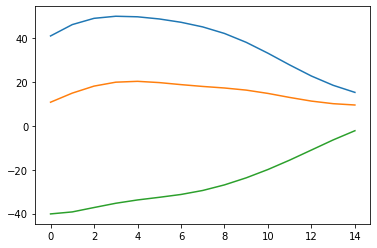

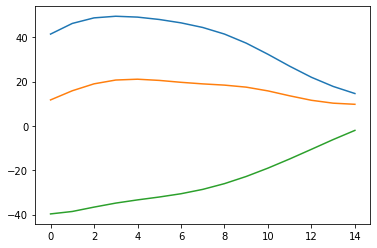

In [31]:
plt.plot(a[0,2,:,:3]);
plt.figure()
plt.plot(b[0,2,:,:3]);